In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy as sp
from scipy.signal import find_peaks
import scipy.constants as const
import pandas as pd
plt.style.use('../report.mplstyle')

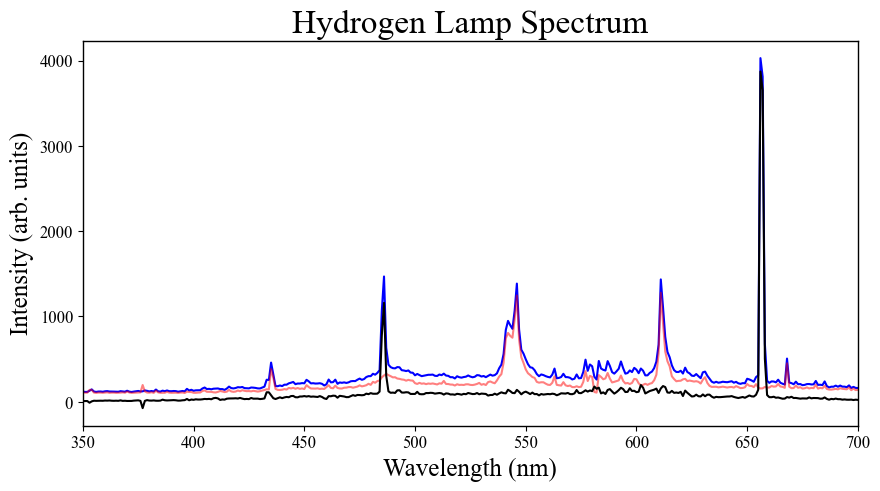

In [6]:
def loadtxt(filename):
    data = np.loadtxt(filename, delimiter='\t', skiprows = 17)
    return data

h_lamp = loadtxt('data/H_lamp/H_lamp0.txt')
background = loadtxt('data/H_lamp/H_lamp_background0.txt')
h_lamp_cor = h_lamp[:,1] - background[:,1]

plt.figure(figsize=(10,5))

plt.plot(h_lamp[:,0], h_lamp[:,1],color = 'blue')
plt.plot(background[:,0], background[:,1], color = 'red',alpha = 0.5)
plt.plot(h_lamp[:,0], h_lamp_cor, color = 'black')
plt.xlabel('Wavelength (nm)')
plt.xlim(350,700)
plt.ylabel('Intensity (arb. units)')
plt.title('Hydrogen Lamp Spectrum')
plt.show()



In [7]:
peaks,peaks_height = find_peaks(h_lamp_cor, height = 45, distance = 22, prominence = 0.1)
peaks = [peaks[0],peaks[1],peaks[3],peaks[9]]
peaks_height = [peaks_height['peak_heights'][0],peaks_height['peak_heights'][1],peaks_height['peak_heights'][3],peaks_height['peak_heights'][9]]


balmer_series = (h_lamp[peaks,0], peaks_height)
wavenumber = (2*np.pi)/(balmer_series[0]*1e-9)
balm_freq = const.c/(balmer_series[0]*1e-9)
energy = const.h*balm_freq
balmer_num = np.array([6,5,4,3])

dic = {
'Wavelength':balmer_series[0],
'Wavenumber': wavenumber,
'Frequency': balm_freq,
'Energy': energy,
'Balmer Number': balmer_num}

balmer = pd.DataFrame(dic)
N1 = 2

In [8]:
df

NameError: name 'df' is not defined

In [ ]:
def ryd_eq(del_e,n2,n1 = N1):
    x = 1/(n2**2) - 1/(n1**2)
    return del_e/(-const.h*const.c*x)

def ryd_eq3(wavelength,n2,n1 = N1):
    x = 1/(n2**2) - 1/(n1**2)
    return 1/((-wavelength*1e-9)*x)
for i in range(4):
    mean_ryd = (np.mean(ryd_eq(energy[i],balmer_num[i])))
    mean_ryd3 = (np.mean(ryd_eq3(balmer_series[0][i],balmer_num[i])))

def n7(n2,n1 = N1):
    x = 1/(n2**2) - 1/(n1**2)
    return 1/(-mean_ryd*x)

print(f'Fifth Balmer line of hydrogen at {n7(7):.4e}m')


Fifth Balmer line of hydrogen at 3.9684e-07m


FIfth balmer line appears in the spectrum but as a very small peak that could be categorized as noise if it wasnt known to be there

In [ ]:
def ion_energy(n):
    return mean_ryd*const.c*const.h/1/(n**2)*1e-3*const.N_A

print(f'First Ionisation energy of hydrogen is {ion_energy(1):.2f} kJ/mol')

First Ionisation energy of hydrogen is 1312.97 kJ/mol


Ionisation energy in eV our value is 13.631 and accepted value in Kaye and Laby is 13.598

# LED section

In [ ]:
red = loadtxt('data/LED/red_led0.txt')
yellow = loadtxt('data/LED/yellow_led0.txt')
blue = loadtxt('data/LED/blue_led0.txt')
green = loadtxt('data/LED/green_led0.txt')
white = loadtxt('data/LED/white_led0.txt')


ValueError: the number of columns changed from 2 to 1 at row 652; use `usecols` to select a subset and avoid this error